# MOA Evaluation using enrichment analysis

- Adopted here: https://www.nature.com/articles/s41467-019-10154-8
- Explained here: https://yulab-smu.github.io/clusterProfiler-book/chapter2.html

### Procedure:
1. Compute similarity / correlation / affinity matrix
1. Define MOA matching criteria based on metadata
  - https://github.com/carpenterlab/2018_rohban_natcomm/blob/master/code/moa_evaluations.R#L67
  - https://github.com/carpenterlab/2018_rohban_natcomm/blob/master/code/evaluate.R#L190
1. Find the threshold of top connections (percentile)
1. Run enrichment analysis (one-sided version of Fisher's exact test)
  - https://github.com/carpenterlab/2018_rohban_natcomm/blob/master/code/moa_evaluations.R#L97
  - https://github.com/carpenterlab/2018_rohban_natcomm/blob/master/code/evaluate.R#L205

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.stats

In [3]:
wells = pd.read_csv("well_level_data.csv")

# Aggregate data into treatment-level profiles

In [4]:
columns1 = ["Plate", "Well", "Gene", "Replicate"]
columns2 = [str(i) for i in range(7680)] 
profiles = wells.groupby("Gene").mean()

In [5]:
# Attach gene names to the dataframe
gene_ids = pd.read_csv("labels.csv")
gene_names = gene_ids.Treatment.str.split("@", expand=True)
gene_names.columns = ["Number", "Gene_Name"]
gene_names["ID"] = gene_names.index
genes = pd.merge(gene_ids, gene_names, on="ID")

profiles = pd.merge(profiles, genes, left_on="Gene", right_on="ID").drop(["Plate", "Replicate"], axis=1)

In [6]:
# Attach MOAs to the dataframe
moas = pd.read_csv("genetic_screen_ground_truth.csv")[["Metadata_moa", "Metadata_gene_name"]]
profiles = pd.merge(profiles, moas, how="left", left_on="Gene_Name", right_on="Metadata_gene_name")

In [7]:
# Remove samples without MOA (according to [1])
profiles = profiles[~profiles["Metadata_moa"].isna()]

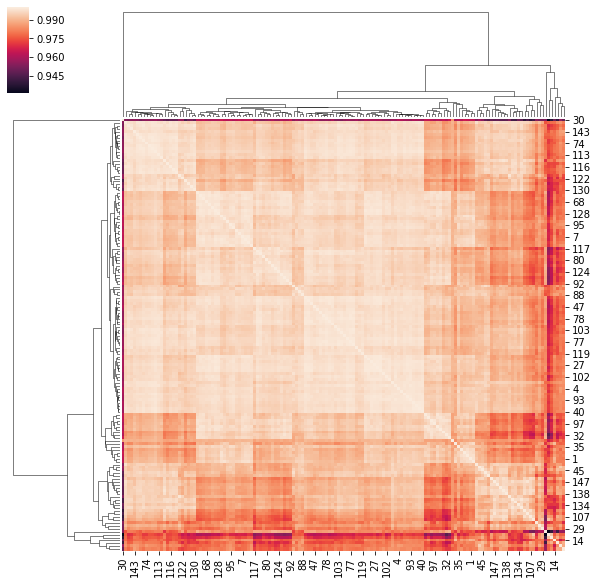

In [8]:
# Compute correlation matrix
CRM = np.corrcoef(profiles[columns2])
sb.clustermap(CRM)

# MOA matching

In [9]:
profiles.groupby("Metadata_moa")["0"].count()

Metadata_moa
Apoptosis                                  5
Autophagy                                  4
BMP                                        4
Cell Cycle                                 5
Chromatin Modifiers                        1
Circadian Rhythm                           5
Cytoskeletal Re-org                        4
DNA Damage                                 2
ER Stress/UPR                              8
Hedgehog                                   2
Hippo                                      3
Hypoxia                                    7
Insulin Receptor Signaling                 3
JAK/STAT                                   3
MAPK                                      19
Mitochondria Oxidative Phosphorylation     2
NFkB                                      16
NOTCH                                      6
PI3K/AKT                                  10
PKA                                        4
PKC                                        2
RTK                                       

In [10]:
moa_matches = []
for k,r in profiles.iterrows():
    m = profiles.Metadata_moa == r.Metadata_moa
    moa_matches.append(m)

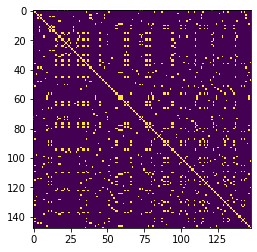

In [11]:
moa_matches = np.asarray(moa_matches)
plt.imshow(moa_matches)

# Enrichment analysis

In [12]:
def enrichment_analysis(corr_matrix, moa_matches, percentile):
    threshold = np.percentile(corr_matrix, percentile)

    v11 = np.sum(np.logical_and(corr_matrix > threshold, moa_matches))
    v12 = np.sum(np.logical_and(corr_matrix > threshold, np.logical_not(moa_matches)))
    v21 = np.sum(np.logical_and(corr_matrix <= threshold, moa_matches))
    v22 = np.sum(np.logical_and(corr_matrix <= threshold, np.logical_not(moa_matches)))

    V = np.asarray([[v11, v12], [v21, v22]])
    #print(V)
    r = scipy.stats.fisher_exact(V, alternative="greater")
    result = {"percentile": percentile, "threshold": threshold, "ods_ratio": r[0], "p-value": r[1]}
    return result

In [13]:
results = []
ut_idx = np.triu_indices(moa_matches.shape[1], k=1)

for p in np.arange(98, 99.7, 0.2):
    r = enrichment_analysis(CRM[ut_idx], moa_matches[ut_idx], p)
    results.append(r)

In [14]:
R = pd.DataFrame(data=results)

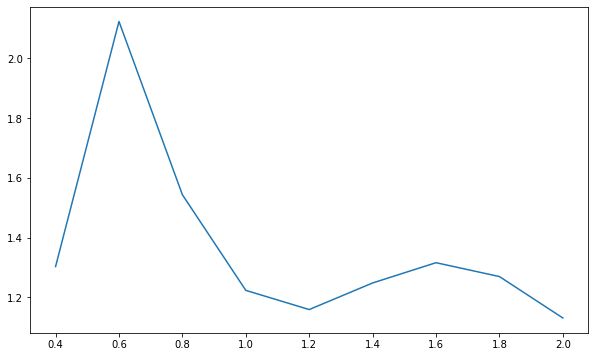

In [15]:
plt.figure(figsize=(10,6))
plt.plot(100-R["percentile"], R["ods_ratio"])